In [1]:
import geopandas as gdp
import pypsa

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Download from https://kart8.nibio.no/nedlasting/dashboard
ar_fn = "0000_4258_ar50_gdb.gdb"

ar = gdp.read_file(ar_fn, engine="pyogrio")

/mnt/research/opt/koen/mambaforge/envs/hydrogen-exports-analysis/lib/python3.10/site-packages/pyogrio/raw.py:194: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  result = ogr_read(


In [21]:
# Convert to equal-area CRS for accurate area calculations
ar_area = ar.to_crs(3035)

ar_area.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

INFO:pypsa.io:Imported network elec_s60_20.nc has buses, carriers, generators, lines, links, loads, storage_units


,geometry
group,
north,"MULTIPOLYGON (((4568284.613 4812877.634, 45689..."
middle,"MULTIPOLYGON (((4271796.054 4485117.799, 42765..."
south,"MULTIPOLYGON (((4086956.279 4040283.622, 40870..."


<AxesSubplot:>

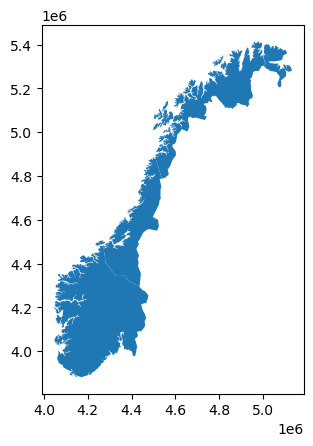

In [22]:
# Load and plot network regions
n = pypsa.Network("../resources/scenario_A/networks/elec_s60_20.nc")
regions = gdp.read_file("../resources/scenario_A/regions_onshore_elec_s60_20.geojson", index_col=0).to_crs(ar_area.crs)
regions.set_index("name", inplace=True)

# Get just the norwegian regions
regions = regions[regions.index.map(lambda x: x.startswith("NO"))]

# Split regions into south, middle, north
regions["group"] = "south"
regions.loc[regions.index.map(n.buses.y) > 63, "group"] = "middle"
regions.loc[regions.index.map(n.buses.y) > 67, "group"] = "north"

# Group regions by group
regions = regions.dissolve(by="group")

# Sort from north to south
regions = regions.loc[["north", "middle", "south"]]

display(regions)

regions.plot()

In [20]:
display(regions.to_crs(3035).area / 1e6)
print(regions.to_crs(3035).area.sum() / 1e6)

group
north      90617.143939
middle     60710.322084
south     159033.285875
dtype: float64

310360.7518986865


In [26]:
snaumark = ar_area.loc[ar_area.artype == 50]

In [27]:
d = snaumark.dissolve()

In [28]:
# Compute area of d
print(d.geometry.area / 1e6)

0    137773.14878
dtype: float64


<AxesSubplot:>

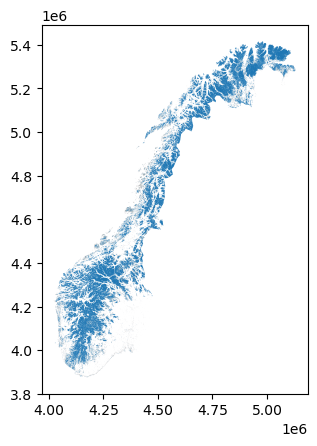

In [31]:
d.plot()

In [33]:
# Compute the amount of area in each region that is snaumark, i.e. that overlays d
for group in regions.index:
    regions.at[group, "snaumark_area"] = regions.at[group, "geometry"].intersection(d.geometry).area / 1e6

/tmp/ipykernel_1606603/1636708098.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  regions.at[group, "snaumark_area"] = regions.at[group, "geometry"].intersection(d.geometry).area / 1e6
/tmp/ipykernel_1606603/1636708098.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  regions.at[group, "snaumark_area"] = regions.at[group, "geometry"].intersection(d.geometry).area / 1e6
/tmp/ipykernel_1606603/1636708098.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  regions.at[group, "snaumark_area"] = regions.at[group, "geometry"].intersection(d.geometry).area / 1e6


In [36]:
# Normlize snaumark area by the total area of snaumark
regions["snaumark_area_norm"] = regions.snaumark_area / regions.snaumark_area.sum()
regions["snaumark_area_norm"] *= d.geometry.area.sum() / 1e6

In [38]:
regions.snaumark_area_norm

group
north     54886.233682
middle    24834.678796
south     58052.236302
Name: snaumark_area_norm, dtype: float64